# Navigation

---

This project demonstrates how to train an agent to navigate and collect bananas in a large, square world, using Deep Reinforcement Learning. 

## A. Examining the Environment

### A.1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### A.2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### A.3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


## B. Training the Agent

We now use The Deep Q Network Reinforcement learning algorithm to train an agent on how to maximize the agent's overall accumalative reward.

In [6]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### B.2. Reset the Environment for Training

Initialize the environment by resetting it in the code cell below. Note that the `train_mode` parameter is set to `True`.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

### B.3. Train the Agent with DQN

Our agent will utilize the DQN algorithm to approximate the optimal action-values across a set of episodes. The following gives a quick overview on the algorithm.

#### B.3.1 The DQN Algorithm

The Deep Q-Network Algorithm was published in the paper "Human-level control through deep reinforcement learning", by Google DeepMind researchers ([link](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)). The algorithm attempted to fix previous problems with estimating action-values, mainly instability using two techniques: 
1. Experience Replay, a technique aiming at averaging the behaviour distribution and avoiding oscillations and extreme divergence in action values in any experience sequence. By replaying a batch of experience tuples in random order it achieves decorrelation when learning. Experience replay thus can potentially use an experience tuple multiple times in weight updates due to averaging, and overall makes better use of experience whether that be frequently experienced action values, or rare occuring experiences.
2. Fixed Q-Targets, uses a fixed network from the previous update step to compute the losses against during learning. This helps convergence as without it, the weight update is optimizating for an ever moving target.
\\[ \Delta w = \alpha \left[ R + \gamma \max_\alpha \hat{q}_{} (S', a, w^- ) - q(S, A, w) \right] \nabla_w q(S, A, w) \\] In the update step above, the target weights $w^-$, is fixed across the learning phase, and updated in the next batch. Note: the update step is slightly different from the one in the paper in terms of notation. 

An overview of the DQN algorithm is shown next.

The DQN algorithm has an initialization step, where we initialize the replay buffer $D$, set of weights $w$ and $w^-$.

Next, we repeat the next two steps alternating, till either a stopping condition is met, or we run out of training episodes:
1. Sample the environment: observe our current state, perform an action, then observe the reward and next state. We store this experience tuple in a replay memory. 
2. Learn: We select a small batch of experience tuples from the replay memory in random order. We learn from that batch using a gradient descent update step.

The algorithm is described in more details in the paper, under the "Methods" section. 

#### B.3.1 The DQN Architecture

The original DQN algorithm had a network architecture of two convolution layers, with ReLU activation, which were feeded a 84x84x4 square grayscale image sequence preprocessed from the Atari 2600 games. Those two convolution layers were then connected to three fully connected Linear layers, also with ReLU activation. The first fully connected layer takes as input the states, while the last layer representing the action-values.

Since in our example, we do not process pixels as the Deepmind agent did -- the experience tuples are already provided -- our architecture consists of only the last fully connected layers of the original DQN algorithm.
So for this example, The dimention of the first linear fully connected layer is 37, the dimension of the hidden layer is 64, the dimension of the output layer is 4.

#### B.3.2. DQN Hyperparameters

`state_size = 37`: Number of possible states for the agent.  
`action_size = 4`: Number of possible actions taken by the agent.  
`fc1_nodes = 64`: Dimension of the hidden fully connected layer.  
`n_episodes = 2000`: maximum number of training episodes.  
`max_t = 1000`: maximum number of timesteps per episode.  
`eps_start = 1.0`: starting value of epsilon, for epsilon-greedy action selection.  
`eps_end = 0.01`: minimum value of epsilon.  
`eps_decay = 0.995`: multiplicative factor (per episode) for decreasing epsilon.  
`req_score = 13.0`: required average score for the agent before stopping to learn.  
`BUFFER_SIZE = 10e5`:  replay buffer size.  
`BATCH_SIZE = 64`: minibatch size.
$\gamma$ = 0.99: discount factor.  
$\tau$ = 1e-3: for soft update of target parameters. i.e., $w_{target} = \tau w_{local} + (1 - \tau) w_{target}$
`LR = 5e-4`: learning rate.  
`UPDATE_EVERY = 4`: how often to update the network.  

#### B.3.3. DQN Implementation

The implementation for the DQN agent can be found in two files: `dqn_agent.py` and `model.py`.

- `model.py` Defines a neural network architecture in that maps states to action values.
- `dqn_agent.py` Defines the classes `Agent` and `ReplayBuffer`.

We instantiate an `Agent` in the below cell.

In [8]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

We now define the DQN function which utilizes the `Agent`, `ReplayBuffer` and `QNetwork` classes.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [9]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, req_score=13.0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        req_score (float): required average score for the agent before stopping to learn
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # Now get next state 
            reward = env_info.rewards[0]                   # ... and reward ...
            done = env_info.local_done[0]                  # are we done?
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= req_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores


We now train the agent aiming at an average score of +14. Run the code cell below to train the agent from scratch.

Episode 100	Average Score: 1.16
Episode 200	Average Score: 4.80
Episode 300	Average Score: 8.16
Episode 400	Average Score: 10.60
Episode 500	Average Score: 12.65
Episode 592	Average Score: 14.06
Environment solved in 492 episodes!	Average Score: 14.06


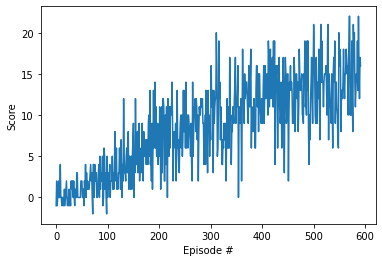

In [10]:
scores = dqn(req_score=14.0)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [11]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    for j in range(1000):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # Now get next state 
        reward = env_info.rewards[0]                   # ... and reward ...
        done = env_info.local_done[0]                  # are we done?
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    
    print('\rEpisode {}\tScore: {:.2f}'.format(i+1, score))


Episode 1	Score: 16.00
Episode 2	Score: 18.00
Episode 3	Score: 15.00
Episode 4	Score: 15.00
Episode 5	Score: 20.00


We can now close the environment.

In [12]:
env.close()

### 5. Outlook for Improvement

There have been several suggested improvements over the original Deep Q Network algorithm. 

 * Double DQN ([link](https://arxiv.org/abs/1509.06461)), which attempts to resolve overestimations of Q-values in normal DQN.
 * Prioritized Experience Replay ([link](https://arxiv.org/abs/1511.05952)), a technique to prioritize experience, so as to replay important transitions more frequently, and therefore learn more efficiently instead of using a uniformly sampled replay buffer -- the latter which replays transitions at the same frequency in which they were experienced.
 * Dueling DQN ([link](https://arxiv.org/abs/1511.06581)), which introduced a network similar in architecture, but instead of action-value approximation, it provides two separate estimators: 1. the state value function and, 2. the state-dependent action advantage function. The benefit of this factoring is to generalize learning across actions without imposing any change to the underlying reinforcement learning algorithm.
 * Learning from multistep bootstrap targets, as in A3C ([link](https://arxiv.org/abs/1602.01783)).
 * Distributional DQN ([link](https://arxiv.org/abs/1707.06887)).
 * Noisy DQN ([link](https://arxiv.org/abs/1706.10295)).
 
While each of the above six improvements aimed as specific yet different issues, researchers at Google Deepmind combined the above into an algorithm called Rainbow ([link](https://arxiv.org/abs/1710.02298)) and showed that it outperformed them when tested together on Atari 2600 games.